In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install onnxruntime
!pip install insightface
!pip install mtcnn
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 120.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 7.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 97.9 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp311-cp311-linux_x86_64.whl size=1064783 sha256=576b9be64f3cbca5e99cb18ff1e0d8291949894624456c041c6e20355bef6492
  Stored in directory: /root/.cache/pip/wheels/27/d8/22/f52d858d16cd06e7b2e6aad34a1777dcfaf000be833bbf8146
Successfully built insightface


In [ ]:
import cv2 as cv
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile
from PIL import Image
from insightface.app import FaceAnalysis
import torch
from torchvision import transforms
from sklearn.metrics.pairwise import cosine_similarity
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
img = cv.imread('/content/drive/MyDrive/dataset/jenna_ortega/4.jpg')

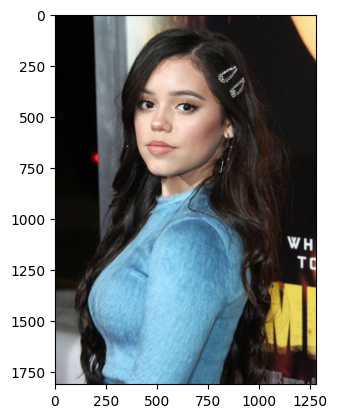

In [ ]:
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
from mtcnn.mtcnn import MTCNN

detector = MTCNN()
result = detector.detect_faces(img)

In [ ]:
result

[{'box': [380, 200, 412, 582],
  'confidence': np.float64(0.9999587535858154),
  'keypoints': {'nose': [np.int64(490), np.int64(542)],
   'mouth_right': [np.int64(600), np.int64(657)],
   'right_eye': [np.int64(643), np.int64(453)],
   'left_eye': [np.int64(458), np.int64(442)],
   'mouth_left': [np.int64(450), np.int64(642)]}}]

In [ ]:
x, y, w, h = result[0]['box']

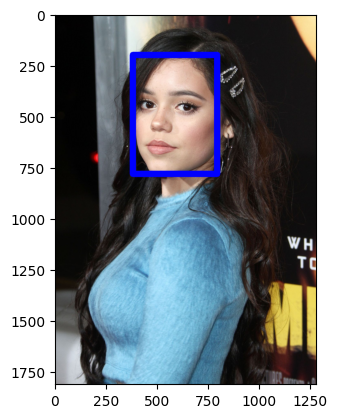

In [ ]:
img = cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 30)
plt.imshow(img)

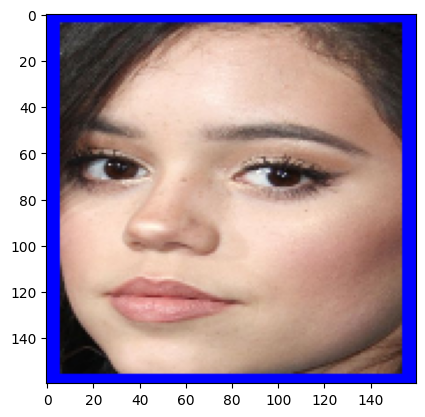

In [ ]:
my_face = img[y:y+h, x:x+w]
my_face = cv.resize(my_face, (160,160))
plt.imshow(my_face)

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       ...,

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]]], dtype=uint8)
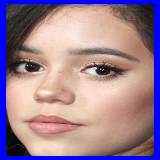

In [ ]:
my_face

In [ ]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []           #Used to store faces
        self.Y = []           #Used to store labels
        self.detector = MTCNN()


    def extract_face(self, filename, required_size=(160, 160)): # Changed to self and filename
        try:
            # image = Image.open(filename).convert('RGB')  # Remove this line as it's not needed
            image = Image.open(filename).convert('RGB') # Opening the file here
            pixels = np.asarray(image)
            results = self.detector.detect_faces(pixels) # Changed to self.detector
            if results:
                x1, y1, width, height = results[0]['box']
                x1, y1 = abs(x1), abs(y1)
                x2, y2 = x1 + width, y1 + height
                face = pixels[y1:y2, x1:x2]
                face_image = Image.fromarray(face)
                face_image = face_image.resize(required_size)
                return np.asarray(face_image)
        except Exception as e:
            print(f"Error processing {filename}: {e}")
        return None


    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path) # Changed to self
                # Append only if a face was detected
                if single_face is not None:
                    FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)

        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')

Load GhostFaceNetV2-1 Model

In [ ]:
app = FaceAnalysis(name="buffalo_l", providers=['CPUExecutionProvider'])
app.prepare(ctx_id=0)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


Extract Embedding

In [ ]:
# Helper: Extract face embedding
def extract_embedding(image_path):
    try:
        img = cv.imread(image_path)
        if img is None:
            return None
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        faces = app.get(img)
        if faces:
            return faces[0].embedding  # 512D vector
    except Exception as e:
        print(f"Error: {e} in {image_path}")
    return None

In [ ]:
# Load dataset and compute embeddings
dataset_path = '/content/drive/MyDrive/dataset'
known_embeddings = {}

for person_folder in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person_folder)
    for filename in os.listdir(person_path):
        full_path = os.path.join(person_path, filename)
        embedding = extract_embedding(full_path)
        if embedding is not None:
            known_embeddings[full_path] = embedding

Compare Embeddings and Group Similar Faces

In [ ]:
# Compare embeddings
threshold = 0.5
match_results = {}

file_paths = list(known_embeddings.keys())
embeddings = list(known_embeddings.values())

for i in range(len(file_paths)):
    face_i = embeddings[i]
    matches = []
    for j in range(len(file_paths)):
        if i == j:
            continue
        face_j = embeddings[j]
        sim = cosine_similarity([face_i], [face_j])[0][0]
        if sim > (1 - threshold):  # Similarity above threshold
            matches.append(file_paths[j])
    match_results[file_paths[i]] = matches

In [ ]:
# Input image to match
input_image_path = '/content/drive/MyDrive/dataset/jenna_ortega/4.jpg'

# Display result
if input_image_path in match_results:
    matched_paths = match_results[input_image_path]
    print(f"\nFace from '{input_image_path}' is recognized in:")
    for match in matched_paths:
        print(f"  - {match}")
else:
    print(f"\nNo matches found for face from '{input_image_path}'")


Face from '/content/drive/MyDrive/dataset/jenna_ortega/4.jpg' is recognized in:
  - /content/drive/MyDrive/dataset/jenna_ortega/3.jpg
  - /content/drive/MyDrive/dataset/jenna_ortega/6.jpg
  - /content/drive/MyDrive/dataset/jenna_ortega/5.jfif
  - /content/drive/MyDrive/dataset/jenna_ortega/7.jpg
  - /content/drive/MyDrive/dataset/jenna_ortega/8.jpg
  - /content/drive/MyDrive/dataset/jenna_ortega/2.jpg
  - /content/drive/MyDrive/dataset/jenna_ortega/9.jpg
  - /content/drive/MyDrive/dataset/jenna_ortega/10.jpg
  - /content/drive/MyDrive/dataset/jenna_ortega/1.jpg
